<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/10.00-Modelos_individuais_implementacao_matricial.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos individuais estocásticos - redes e parâmetros](09.00-Modelos_individuais_redes_e_parametros.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos individuais estocásticos - implementação vetorial ->](11.00-Modelos_individuais_implementacao_vetorial.ipynb)

---


# Modelos individuais - implementação inicial

## Objetivos

- Continuar o estudo de **modelos estocásticos individuais espacialmente estruturados e com evolução temporal discreta.**

- Implementação de uma versão sintética e simplificada do modelo do **Imperial College**

**Importando bibliotecas e definindo funções a serem usadas abaixo**

In [1]:
import datetime as dt # date and time tools

from collections import namedtuple

from os import path

import random

import numpy as np
from scipy.integrate import solve_ivp

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 06/May/2020


In [3]:
sns.set_style("darkgrid")

## O Modelo

### Parâmetros utilizados na simulação do Imperial College

- **Período de incubação** de 5,1 dias.

- **Início do período de contágio:**

    - a partir de 12h antes do desenvolvimento dos sintomas, no caso dos sintomáticos
    
    - a partir de 4,6 dias após a infecção, no caso dos assintomáticos, com um perfil temporal de infecção que resulta em uma média de 6,5 dias de tempo de geração médio (no caso dos assintomáticos, é assumido que a taxa de infecção decai com o tempo).

- É assumido que os **sintomáticos são 50% mais infecciosos que os assintomáticos.**

- Com base nos dados iniciais da epidemia em Wuhan, é assumido que $R_0 = 2.4$, mas valores entre $2.2$ e $2.6$ também são examinados.
    
- A **taxa de infecção individual** é assumida variável, modulada por uma distribuição gamma com média 1 e um parâmetro de forma $\alpha = 0.25$ (logo $k=\alpha$, média $\theta k = \theta\alpha = 1$ e parâmetro de escala inversa $\beta = 1/\theta = k = 0.25$).    

#### Infectados iniciais

- Inicialmente, é assumido um crescimento exponencial de infectados, a partir do início de janeiro de 2020.

- É assumido um **tempo de duplicação** de 5 dias.

- O dado inicial é **calibrado segundo os dados de óbitos** até o dia 14 de março de 2020.

### Descrição do modelo no artigo Ferguson et al (2006)

- Passos temporais de $\Delta t = 0.25 \,\texttt{dias} = 6\,\texttt{horas}$.

- A cada passo de tempo, um indivíduo suscetível tem probabilidade $1 - e^{-\lambda_i \Delta t}$ de ser infectado, onde $\lambda_i$ é a taxa de risco instantâneo de infecção.

- $\lambda_i$ vem de três fontes: residência, local de trabalho e encontros aleatórios (mais detalhes nas [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf) do artigo [Ferguson et al (2005)](#Referências)

- O contatos aleatórios dependem da distância através do uso de "modelos de gravidade" (?), representando contatos aleatórios associados a deslocamentos e viagens.
    
- O *kernel* de decaimento espacial tem a mesma forma que a função de alocação de trabalhadores: $f(d) = 1/(1+(d/a)^b)$, onde $a=4\,\texttt{km}$ e $b=3$.
    

### Descrição do modelo

- Usamos o modelo genérico conforme descrito nas [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf) do [Ferguson et al (2005)](#Referências).

- A **região geográfica** é um domínio $\Omega\subset \mathbb{R}^2$.

- A **população total** é um inteiro $N$.

- Há um determinado número de **residências**.

- Há quatro tipos de **lugares** (*places*), $n_p = 1, 2, 3, 4$, com os três primeiros representando tipos de **escola**, segundo a escolarização, e o último, o **local de trabalho**.

- Um **indivíduo** $i\in \{1, \ldots, N\}$ é representado por

    - sua **idade** $a_i$;
    
    - sua **residência** $h_i$ (determinada pela função de densidade populacional e dados de censo da pirâmide etária);

    - seu **local de estudo/trabalho** $l_i^j$;
    
    - o seu **estado** $I_i$, de acordo com $I_i = 1$, se infectado (ou contagioso?), ou $I_i=0$, caso contrário.
    
    - o **grau da infecção** $C_i$, de acordo com $C_i=1$, se severa, ou $C_i=0$, caso contrário. A cada nova infecção, o indivíduo recém-infectado é aleatoriamente selecionado se $C_i=0$ ou $1$, com 50% de chance para cada grau.
    
    - o **instante de infecção** $\tau_i$, indicando o instante em que o indivíduo $i$ se tornou infectado (contagioso?)
    
    - a **força de infecção** $\lambda_i$, detalhada mais abaixo.
    
- Quantidades derivadas:

    - $n_i$ é o **número de pessoas na residência** do indivíduo $i$;
    
    - $m_i^j$ é o **número de pessoas no mesmo local** do indivíduo $i$.

### Força de infecção

A **força de infecção** $\lambda_i$ de cada indivíduo é dada por

$$ 
  \begin{align*}
    \lambda_i & = \frac{1}{n_i^\alpha}\sum_{k; h_k = h_i}  I_k \beta_h\kappa(t-\tau_k)\rho_k(1 + C_k (\omega-1)) \quad \textrm{(na residência)} \\
    & \quad + \sum_{j, k; l_k^j = l_i^j} \frac{I_k \beta_p^j\kappa(t-\tau_k)\rho_k(1 + C_k(\omega\psi_p^j(t-\tau_\kappa)-1)}{m_i^j} \quad \textrm{(na local de escola/trabalho)} \\
    & \quad + \frac{\sum_k I_k\zeta(a_i)\beta_c\kappa(t-\tau_k)f(d_{ik})\rho_k(1 + C_k (\omega-1))}{\sum_k f(d_{ik})} \quad \textrm{(global)},
  \end{align*}
$$

onde

- $i, k$ são índices de indivíduos;

- $j$ é um índice de local;

- $\beta_k$, $\beta_p^j$ e $\beta_c$ são coeficientes de transmissão em **residências**, **locais de trabalho/escola** e em toda a região (rede **global**);

- $\alpha=0.8$ é uma potência para escalonar em função do tamanho da residência;

- $\omega=2$ é um fator de contágio para infecções severas, em relação a não-severas.

- $\psi_p^j = 0.1, 0.2, 0.25, 0.5$, para $j=1,2,3,4$ e $s>0.25 \;\texttt{dias}$, e $\psi_p^j=0$, caso contrário, são os fatores de taxa de contato, em cada tipo de local, para infecções severas, como função do tempo $s=t-\tau$ desde o início do contágio.

- $f(d_{ik})$ é o núcleo de distância e $d_{ik}$ é a distância euclidiana entre os indivíduos $i$ e $k$.

- $\zeta(a_i)$ é a taxa relativa de contato em relação à mobilidade de um indivíduo com idade $a_i$.

- $\rho_k = 1$ é a taxa relativa de infecção do indivíduo $k$. (Mais geralmente $\rho_k$ pode ser dado por uma distribuição $\gamma$ com média $1$ e fator de forma $\alpha=0.2$.)

### Parâmetros utilizados na simulação de uma epidemia na Tailândia

- Almejamos $R_0 = 2.4$ total.

- Precisamos saber a taxa de recuperação para poder obter a taxa $\beta$ de cada rede.

- $\beta_h = 0.4/\texttt{dia}$, correspondendo a $R_0 = 0.6$ (nas residências);

- Particiona os coeficientes de transmissão fora das residências em partes iguais em relação aos valores correspodentes de $R_0$, sendo que o das escolas é o dobro do dos trabalhos:

    - $\beta_e^j = 0.94/\texttt{dia}$ (nas escolas - $j=1,2,3$);
    
    - $\beta_t= 0.47/\texttt{dia}$ (no trabalho);
    
    - $\beta_c = 0.075/\texttt{dia}$ (global).

### Força de infecção com parâmetros uniformes

- No modelo de $\lambda_i$ do Imperial College, suponha que 
    
    - As taxas não decaem com o tempo, nem haja atraso: $\kappa\equiv 1$;
    
    - Todos os indivíduos tenham a mesma susceptibilidade: $\rho_k \equiv 1$;
    
    - Não haja diferença no grau de infecção: $C_k \equiv 0$;
    
    - O escalonamento em relação ao tamanho da residência é dado com $\alpha = 1$.
    
    - A idade do indivíduo não seja levada em consideração $\zeta\equiv 1$.
    
- Então $\lambda_i$ é reduzido a

$$ \begin{multline*}
  \lambda_i = \frac{1}{n_i}\sum_{k; h_k = h_i}  I_k \beta_h  + \sum_{j, k; l_k^j = l_i^j} \frac{I_k \beta_p^j}{m_i^j} + \frac{\sum_k I_k\beta_c f(d_{ik})}{\sum_k f(d_{ik})} \\ 
= \frac{\beta_h}{n_i}\sum_{k; h_k = h_i}  I_k  + \sum_j \frac{\beta_p^j}{m_i^j}\sum_{k; l_k^j = l_i^j} I_k + \frac{\beta_c}{\sum_k f(d_{ik})}\sum_k I_k f(d_{ik}).
  \end{multline*}
$$

### Taxas de transmissão de cada rede

- Podemos escrever

$$ \lambda_i = \frac{\beta_h}{n_i}\sum_{k; h_k = h_i}  I_k  + \frac{\beta_p^{j_i}}{m_i^{j_i}}\sum_{k; l_k^j = l_i^j} I_k + \frac{\beta_c}{\sum_k f(d_{ik})}\sum_k I_k f(d_{ik}).
$$

onde  $j_i$ indica a escola ou local de trabalho que o indivíduo $i$ frequenta (com $m_i^{l} = 0$ para $l\neq j_i$, de modo que o somatório anterior é simplificadao).

- Dessa forma, vemos que cada termo multiplicando o somatório em $k$ indica a **taxa de transmissão** do indivíduo, em cada grupo a que pertence:

$$ \tau_\textrm{residência} = \frac{\beta_h}{n_i}, \qquad \tau_\textrm{social} = \frac{\beta_p^{j_i}}{m_i^{j_i}}, \qquad  \tau_\textrm{global} = \frac{\beta_c}{\sum_k f(d_{ik})}
$$

### Taxa de transmissão comparada com a anterior

- Temos, então 

$$ \tau_\textrm{residência} = \frac{\beta_h}{n_i}, \quad \tau_\textrm{social} = \frac{\beta_p^{j_i}}{m_i^{j_i}}, \quad  \tau_\textrm{global} = \frac{\beta_c}{\sum_k f(d_{ik})}
$$

- O que fizemos inicialmente foi considerar, efetivamente, uma mesma taxa de transmissão para todos:

$$ \tau = \frac{\beta}{\langle n_i + m_i^{j_i} + \sum_k f(d_{ik}) \rangle},
$$

onde $\langle \cdot \rangle$ indica média em relação ao total de conexões.

- Claramente, a diferença pode ser enorme.

### Fator de transmissão em forma vetorial

- Nesse primeiro momento, vamos considerar a **força de infecção** da forma

$$  \lambda_i = \frac{\beta_h}{n_i^\alpha}\sum_{k; h_k = h_i}  I_k + \frac{\beta_p}{m_i^{j_i}}\sum_{j, k; l_k^j = l_i^j} I_k + \frac{\beta_c}{\sum_k f(d_{ik})} \sum_k I_k f(d_{ik}),
$$

- Em forma vetorial,

$$ \lambda_i = \left( \frac{\beta_h}{n_i^\alpha}a_{ik}^r + \frac{\beta_p}{m_i^{j_i}} a_{ik}^s + \frac{\beta_c}{\sum_k f(d_{ik})} a_{ik}^g \right)_k \cdot I_k,
$$

onde $a_{ik}^r, a_{ik}^s, a_{ik}^g$ são os coeficientes das matrizes de adjacência dos grafos de residência, de local de estudo ou de trabalho e global. 

- Mais precisamente, $a_{ik}^r$ e $a_{ik}^s$ são iguais a $1$ ou $0$, dependendo se há conexão ou não.

- E $a_{ik}^g = f(d_{ik})$, pois já inclui o peso dado pela distância.

### Matriz de transmissão

- Em forma matricial,

$$ \Lambda = \mathcal{T} I,
$$

onde $\Lambda = (\lambda_i)_i$, $I = (I_k)_k$ e $\mathcal{T}$ é a **matriz de taxa de transmissão**

$$ \mathcal{T} = \left( \frac{\beta_h}{n_i^\alpha}a_{ik}^r + \frac{\beta_p}{m_i^{j_i}} a_{ik}^s + \frac{\beta_c}{\sum_k f(d_{ik})} a_{ik}^g \right)_{ik}
$$

- A matriz $\mathcal{T}$ não muda com o tempo e pode ser calculada apenas no início da simulação (ou em tempos espaçados de acordo com as políticas de quarentena e distânciamento social.

- Porém, apesar dos **dois primeiros termos** de $\mathcal{T}$ formarem **matrizes esparsas**, **o último** forma uma **matriz completamente cheia**, o que é bastante custoso em termos de memória.

- Por exemplo, mesmo que usemos `np.float16` para os coeficientes da matriz, isso nos exige 2 bytes por coeficiente, o que, para apenas 2048 indivíduos, requer uma matriz $2048 \times 2048$, o que exige da ordem de 8Gb de memória.

- Se quisermos trabalhar com milhões de indivíduos, ou mesmo dezenas de milhares, precisaremos armazenar a matriz em disco.

- De qualquer forma, há muito a ser melhorado para acelerar o código.

### Construindo a matriz de transmissão

- Usar um atributo, digamos `transmissao`, associado a cada aresta de cada rede, para que a matriz de adjacências forme a matriz de taxa de transmissão.

- No caso das redes de residências e de locais de estudo e trabalho, os pesos das arestas nos dão $a_{ik}$  igual a $1$ ou $0$, dependendo se há, ou não, conexão.

- No caso da rede global, os pesos das arestas já nos dão os coeficientes $a_{ik}^g = f(d_{ik})$.

- A esses coeficientes, devemos multiplicar a taxa de contágio correspondente, i.e. $\beta_h$, $\beta_p$, ou $\beta_c$).

- E dividir pelo número de contatos de cada indivíduo, i.e. $n_i^\alpha$, $m_i^{j_i}$, ou $\sum_k f(d_{ik})$.

- Observe que $d_{ik}=d_{ki}$, assim como $n_i=n_k$ e $m_i^{j_i} = m_k^{j_k}$, para indivíduos na mesma residência ou no mesmo local de estudo ou trabalho. Portanto, isso mantém a estrutura de um grafo não-orientado e de uma matriz de adjacências simétrica.

- Quando incluirmos dependência na idade, uma taxa de contágio aleatória e diferentes fatores de contato, podemos ou considerar um grafo orientado ou tratar esses termos separadamente.

## Parâmetros da epidemia

- Abaixo, definimos as taxas de $\beta$ e $\gamma$ assim como parâmetros para as simulações do modelo SIR compartimental, para comparação.

- Também definimos o número de simulações para o modelo estocástico.

- As condições iniciais (população e número inicial de infectados) são definidas posteriormente.

In [4]:
beta = 0.5

beta_r = 0.18
beta_s = 0.22
beta_c = 0.04

gamma = 0.1
R0 = beta/gamma
alpha= 0.8
T = 60
tempos = np.array(range(T+1))
num_sim = 20
print(f'Número básico de reprodução = {R0:.2f}')

Número básico de reprodução = 5.00


## Funções de evolução e de análise

- Reproduzimos algumas funções utilizadas na última aula para facilitar as simulações.

    - `evolucao_SIR`

    - `analise_grafo`

    - `evolucao_grafo`
    
- **Observação:** Fizemos uma alteração na função `analise_grafo()` para que o cálculo do número de conexões leve o "peso" (`weight`) da aresta em consideração.

In [5]:
def evolucao_SIR(pop_0, beta, gamma, tempos, plot=False):

    SIR_Compartimental = namedtuple('SIR_Compartimental', 
                                 [
                                     'pop_0',
                                     'num_pop',
                                     'beta',
                                     'gamma',
                                     't_instantes',
                                     'S',
                                     'I', 
                                     'R',
                                     'X'
                                 ])        
          
    def diferencial(t, X, N, beta, gamma):
        S, I = X
        dXdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
        return dXdt        
    
    num_pop = sum(pop_0)
    y0 = pop_0[0:2]
    sol = solve_ivp(diferencial, t_span=[tempos[0],tempos[-1]], 
                    y0 = y0, t_eval = tempos,
                    args=(num_pop, beta, gamma))
    
    resultado = SIR_Compartimental(pop_0, num_pop, beta, gamma, tempos,
                                   sol.y[0], sol.y[1], num_pop - sol.y[0] - sol.y[1], sol)
    return resultado

In [6]:
def analise_grafo(G, info=True, node_size=0, pos=None, hist=False):

    num_vertices = G.number_of_nodes()
    num_arestas = G.number_of_edges() # usado na versão antiga
    num_arestas_weighted = G.size(weight='weight') # usado na versão atual
    num_arestas_por_vertice_weighted = [j for i,j in G.degree(weight='weight')]
    num_medio_conexoes = 2*num_arestas_weighted/num_vertices
    num_medio_conexoes = sum([d[1] for d in G.degree(weight='weight')])/G.number_of_nodes()

    if info:
        print(f'Número de vértices: {num_vertices}')
        print(f'Número de arestas: {num_arestas}')
        print(f'Número de arestas com peso: {num_arestas_weighted}')
        print(f'Número médio de conexões por indivíduo: {num_medio_conexoes:.1f}')

    if node_size:
        color = ['tab:blue', 'tab:red', 'tab:green']
        pop_estado = nx.get_node_attributes(G,'estado')
        color_map = [color[pop_estado[j]-1] for j in range(num_vertices)]
        plt.figure(figsize=(10,6))
        if pos:
            nx.draw(G, pos, node_size=node_size, node_color=color_map, alpha=0.5)
        else:
            nx.draw(G, node_size=node_size, node_color=color_map, alpha=0.5)
        plt.title('Rede de indivíduos e de suas conexões', fontsize=16)
        plt.show()

    if hist:
        plt.figure(figsize=(10,6))
        plt.hist(num_arestas_por_vertice_weighted, 50, facecolor='g', alpha=0.75)
        plt.xlabel('num. arestas', fontsize=14)
        plt.ylabel('num. vertices', fontsize=14)
        plt.title('Histograma com a quantidade de indivíduos por número de conexões', fontsize=16)
        plt.show()
    return num_medio_conexoes

In [7]:
def evolucao_grafo_estruturado(pop_0, G, gamma, tempos, num_sim, show=''):
    """Evolução temporal da epidemia em um grafo estruturado.


    Entrada:
        pop_0: numpy.array
            state of the population, with 
                1: suscetível
                2: infectado
                3: recuperado ou removido

        G: numpy.array
            grafo de conexões, com atributo `taxa de transmissao`

        gamma: float
            taxa de recuperação por unidade de tempo

        tempos: numpy.array
            instantes de tempo

        num_sim: int
            número de simulações

        show: str
            indica se é para exibir um gráfico e de que tipo:
                - 'nuvem': exibe uma nuvem com todas as simulações e o valor médio em destaque
                - 'sd': exibe o valor médio com uma faixa dada pelo desvio padrão
                - 'sdc': exibe o valor médio com uma faixa dada pelo desvio padrão corrigido
                - 'media': exibe apenas o valor médio
                - '': não exibe gráfico algum.

    Saída
        X: class.SIR_Individual
            Uma instância da classe `SIR_Individual` com os seguintes atributos:
                pop_0:
                num_pop:
                tau:
                gamma:
                tempos:
                num_sim:
                S_mean:
                I_mean: 
                R_mean:
                I_sigma:
                R_sigma:
                S_sigma:
    """

    def passo_grafo_estruturado(num_pop, populacao, T_prob_nao_infeccao, prob_nao_recuperacao):
        
        # gera uma matriz cheia aleatória (números em [0.0,1.0))
        A_random = np.random.rand(num_pop, num_pop)
        
        # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
        pop_suscetiveis = np.select([populacao==1], [populacao])
        
        # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectado/contagioso
        pop_infectados = np.select([populacao==2], [populacao])/2
        
        # cria uma matriz aleatória de risco, mantendo apenas as conexões que envolvem infectados
        A_risco_random = np.multiply(np.tile(pop_infectados, (num_pop, 1)), A_random)
        
        # filtra a matriz aleatória mantendo apenas os contatos entre um suscetível e um infectado
        A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_pop, 1)).transpose(), A_risco_random)
        
        # cria uma matriz de 1's e 0's, indicando se houve, ou não, contágio
        A_infectados = np.select([A_contatos > T_prob_nao_infeccao], [np.ones([num_pop, num_pop])])

        # obtém novos infectados
        pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_pop)])
        
        # filtra matriz aleatória com a diagonal
        pop_recuperando = pop_infectados @ np.multiply(np.eye(num_pop), A_random)
        
        # obtém novos recuperados
        pop_novos_recuperados = np.select([pop_recuperando > prob_nao_recuperacao], [np.ones(num_pop)])
        
        # atualiza população adicionando um aos que avançaram de estágio
        populacao_nova = populacao + pop_novos_infectados + pop_novos_recuperados

        # Observe que cada elemento da matriz aleatória é usado apenas uma vez, garantindo
        # a independência desses eventos aleatórios (tanto quanto se leve em consideração
        # que os números gerados são pseudo-aleatórios)

        return populacao_nova

    
    # confere se escolha para `show` é válida
    if show:
        assert(show in ('nuvem', 'sd', 'media')), 'Valor inválido para argumento `show`.'

    # atributos de saída
    SIR_Individual = namedtuple('SIR_Individual', 
                                [
                                    'pop_0',
                                    'num_pop',
                                    'gamma',
                                    'tempos',
                                    'num_sim',
                                    'S_mean',
                                    'I_mean', 
                                    'R_mean',
                                    'S_sigma',
                                    'I_sigma', 
                                    'R_sigma',
                                ])
    
    # número de indivíduos da população
    num_pop = len(pop_0)
    I_0 = np.count_nonzero(pop_0==2)        

    # número de instantes no tempo e passos de tempo 
    num_t = len(tempos)
    passos_de_tempo = tempos[1:] - tempos[:-1]

    # inicializa variáveis para o cálculo da média
    S_mean = np.zeros(num_t)
    I_mean = np.zeros(num_t)
    R_mean = np.zeros(num_t)

    # inicializa variáveis para o cálculo do desvio padrão
    S_sigma = np.zeros(num_t)
    I_sigma = np.zeros(num_t)
    R_sigma = np.zeros(num_t)
    
    # obtém matriz de adjacências e o número médio de vizinhos do grafo
    T_adj = nx.to_numpy_matrix(G, weight = 'taxa de transmissao')

    # prepara gráfico se necessário
    if show:    
        # inicializa figura e define eixo vertical
        plt.figure(figsize=(12,6))
        plt.ylim(0, num_pop)
        plt.xlim(tempos[0], tempos[-1])
    
    if show == 'nuvem':
        # alpha para a nuvem de gráficos das diversas simulaçõe
        alpha = min(0.2, 5/num_sim)    

    # simulações
    for j in range(num_sim):

        # inicializa população de cada simulação
        populacao = np.copy(pop_0)
        S = np.array([num_pop - I_0])
        I = np.array([I_0])
        R = np.array([0])
     
        
        # evolui o dia e armazena as novas contagens
        for dt in passos_de_tempo:

            # calcula probabilidades
            T_prob_nao_infeccao = np.exp(-dt*T_adj)
            prob_nao_recuperacao = np.exp(-gamma*dt)

            populacao = passo_grafo_estruturado(num_pop, populacao,
                                                T_prob_nao_infeccao, prob_nao_recuperacao)
            S = np.hstack([S, np.count_nonzero(populacao==1)])
            I = np.hstack([I, np.count_nonzero(populacao==2)])
            R = np.hstack([R, np.count_nonzero(populacao==3)])
            
        # adiciona as contagens dessa simulação para o cálculo final da média
        S_mean += S
        I_mean += I
        R_mean += R

        # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
        S_sigma += S ** 2
        I_sigma += I ** 2
        R_sigma += R ** 2

        if show == 'nuvem':
            # exibe os gráficos dos dados de cada simulação
            plt.plot(tempos, S, '-', color='tab:green', alpha=alpha)
            plt.plot(tempos, I, color='tab:red', alpha=alpha)
            plt.plot(tempos, R, '-', color='tab:blue', alpha=alpha)
            plt.plot(tempos, num_pop - S, '-', color='tab:gray', alpha=alpha)

    # divide pelo número de evoluções para obter a média
    S_mean /= num_sim
    I_mean /= num_sim
    R_mean /= num_sim

    # ajusta o calcula do desvio padrão
    S_sigma = ( S_sigma / num_sim - S_mean**2 )**.5
    I_sigma = ( I_sigma / num_sim - I_mean**2 )**.5
    R_sigma = ( R_sigma / num_sim - R_mean**2 )**.5
    
    S_sigma_cor = ( num_sim * S_sigma**2 / (num_sim - 1) )**.5
    I_sigma_cor = ( num_sim * I_sigma**2 / (num_sim - 1) )**.5
    R_sigma_cor = ( num_sim * R_sigma**2 / (num_sim - 1) )**.5

    # exibe os gráficos das médias
    if show == 'sd':
        plt.fill_between(tempos, S_mean - S_sigma, S_mean + S_sigma, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_sigma, I_mean + I_sigma, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_sigma, R_mean + R_sigma, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_sigma, num_pop - S_mean + S_sigma, facecolor='tab:gray', alpha = 0.2)
        
    if show:
        plt.plot(tempos, S_mean, '-', color='tab:green', label='suscetíveis')
        plt.plot(tempos, I_mean, '-', color='tab:red', label='infectados')
        plt.plot(tempos, R_mean, '-', color='tab:blue', label='recuperados')
        plt.plot(tempos, num_pop - S_mean, '-', color='tab:gray', label='inf.+ rec.')
        
    if show == 'nuvem':
        plt.title('Evolução do conjunto de simulações e da média', fontsize=16)
    elif show == 'sd':
        plt.title('Evolução da média, com o desvio padrão', fontsize=16)
    elif show == 'media':
        plt.title('Evolução da média das simulações', fontsize=16)

        
    # informações para o gráfico
    if show:
        plt.xlabel('tempo', fontsize=14)
        plt.ylabel('número de indivíduos', fontsize=14)
        plt.legend(fontsize=12)
        plt.show() 

    resultado = SIR_Individual(
        pop_0,
        num_pop,
        gamma,
        tempos,
        num_sim,
        S_mean,
        I_mean, 
        R_mean,
        I_sigma,
        R_sigma,
        S_sigma
    )

    return resultado

## Construindo as camadas de redes de conexão

- Posicionamento

- Rede de residências.

- Rede social (escola e trabalho).

- Rede global.

### Posicionamento

Construimos essa rede com os seguintes passos:

1. Dividimos o espaço em áreas retangulares.

2. Definimos a população em cada área dessas.

3. Posicionamos os indivíduos, aleatoriamente, em cada área correspondente, de acordo com a população em cada área dessas.

4. Essas posições vão para uma variável do tipo `dict`, onde a chave é o número do indivíduo/vértice e o valor é uma `tuple` com as duas coordenadas espaciais de cada indivíduo.

5. Finalmente, criamos a rede com a função [nx.random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.random_geometric_graph.html). Outra opção é [nx.thresholded_random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.thresholded_random_geometric_graph.html), que é equivalente ao anterior quando o seu argumento `theta` daquele é igual a 0, exceto que ela ainda confere um "peso" ao vértice.

6. Essa rede faz conexões segundo a proximididade e uma certa probabilidade ocorrência.

#### Habitantes por área

Primeiro, definimos a matriz representando o número de habitantes por "bairro", ou, mais precisamente, área retângular.

In [8]:
densidade = np.array(
    [[16, 11, 0, 0,  0,  6,  4,  8,  8,  6],
     [10, 12, 12, 6, 8, 9,  8,  6,  7,  5],
     [0, 10, 14, 10, 12,  8,  0,  0,  6,  8],
     [0, 12, 10, 14, 11,  9,  0,  0,  5,  7],
     [9, 11, 0, 12, 10,  7,  8,  7,  8, 0]
    ])

**Visualização da matriz:**

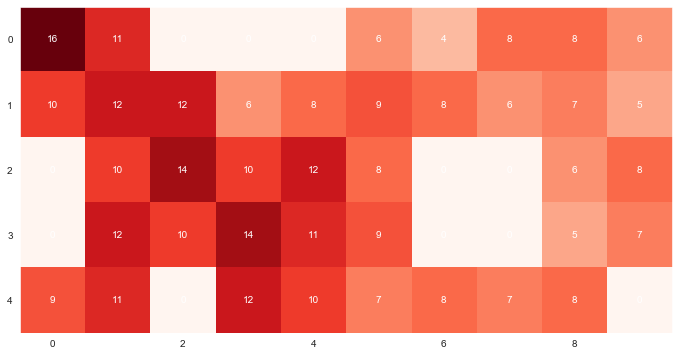

In [9]:
plt.figure(figsize=(12,6))
plt.imshow(densidade, cmap='Reds', interpolation='nearest')
N, M = densidade.shape
for i in range(N):
    for j in range(M):
        plt.text(j, i, densidade[i, j],
                 ha="center", va="center", color="w")
plt.grid(False)
plt.show()

#### Distribuição da população

Em seguida, distribuímos os habitantes aleatoriamente segundo a divisão populacional por área retangular.

In [10]:
np.random.seed(seed = 127)
attr_pos = dict()
k = 0
for m in range(M):
    for n in range(N):
        for i in range(densidade[n,m]):
            attr_pos.update({k: [m + np.random.rand(), N - n + np.random.rand()]})
            k += 1
num_pop = k

#### Estado inicial da população

Com base nessa população inicial, definimos quantos e quais indivíduos estão infectados.

Dessa vez, vamos definir um `numpy.array` de tipo `uint8`, ou seja, inteiro de 8 bits sem sinal, que pode assumir valores inteiros entre 0 a 255.

Lembrando a interpretação com base no modelo SIR:

- `1`: suscetível;

- `2`: infectado;

- `3`: recuperado ou removido.

In [11]:
# estado inicial da população
np.random.seed(seed = 342)
I_0 = 6
#pop_0 = np.ones(num_pop, dtype=np.uint8)
pop_0 = np.ones(num_pop)
infectados_0 = np.random.choice(num_pop, I_0, replace=False)
#pop_0[infectados_0] = 2*np.ones(I_0, dtype=np.uint8)
pop_0[infectados_0] = 2*np.ones(I_0)

#### Idade dos indivíduos

Também definimos a idade de cada indivíduo.

Nesse momento, isso é feito apenas com base na pirâmide etária do Brasil. 

Posteriormente, o ideal é nos basearmos, também, na distribuição etária em função do tamanho das residências.

Dados da [pirâmide etária do Brasil do senso de 2010](https://censo2010.ibge.gov.br/sinopse/webservice/frm_piramide.php) nos dão a seguinte distribuição:

In [12]:
censo_5 = {'0 a 4 anos': [7016987, 6779172],
           '5 a 9 anos': [7624144, 7345231],
           '10 a 14 anos': [8725413, 8441348],
           '15 a 19 anos': [8558868, 8432002],
           '20 a 24 anos': [8630227, 8614963],
           '25 a 29 anos': [8460995, 8643418],
           '30 a 34 anos': [7717657, 8026855],
           '35 a 39 anos': [6766665, 7121916],
           '40 a 44 anos': [6320570, 6688797],
           '45 a 49 anos': [5692013, 6141338],
           '50 a 54 anos': [4834995, 5305407],
           '55 a 59 anos': [3902344, 4373875],
           '60 a 64 anos': [3041034, 3468085],
           '65 a 69 anos': [2224065, 2616745],
           '70 a 74 anos': [1667373, 2074264],
           '75 a 79 anos': [1090518, 1472930],
           '80 a 84 anos': [668623, 998349],
           '85 a 89 anos': [310759, 508724],
           '90 a 94 anos': [114964, 211595],
           '95 a 99 anos': [31529, 66806],
           'Mais de 100 anos': [7247, 16989]
          }

In [13]:
censo_parciais = [a + b for a,b in list(censo_5.values())]
censo_10 = {'0 a 9 anos': sum(censo_parciais[0:2]),
            '10 a 19 anos': sum(censo_parciais[2:4]),
            '20 a 29 anos': sum(censo_parciais[4:6]),
            '30 a 39 anos': sum(censo_parciais[6:8]),
            '40 a 49 anos': sum(censo_parciais[8:10]),
            '50 a 59 anos': sum(censo_parciais[10:12]),
            '60 a 69 anos': sum(censo_parciais[12:14]),
            '70 a 79 anos': sum(censo_parciais[14:16]),
            '80 ou mais anos': sum(censo_parciais[16:])
           }

In [14]:
censo_total = sum(censo_parciais)
censo_fracoes = {k:v/censo_total for k, v in censo_10.items()}

In [15]:
for k, v in censo_fracoes.items():
    print(f'{k}: {100*v:.1f}%')

0 a 9 anos: 15.1%
10 a 19 anos: 17.9%
20 a 29 anos: 18.0%
30 a 39 anos: 15.5%
40 a 49 anos: 13.0%
50 a 59 anos: 9.7%
60 a 69 anos: 5.9%
70 a 79 anos: 3.3%
80 ou mais anos: 1.5%


Sorteando as idades

In [16]:
pop_idades = np.random.choice(9, 350, p=list(censo_fracoes.values())).astype(np.uint8)
dist = [sum([a == age for a in pop_idades]) for age in range(9)]

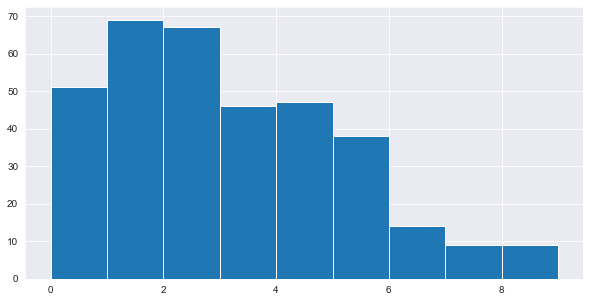

In [17]:
plt.figure(figsize=(10,5))
plt.hist(pop_idades, bins=9, range=(0,9))
plt.show()

#### Construção da rede residencial

Finalmente, construimos a rede.

In [18]:
#G_r = nx.random_geometric_graph(num_pop, 0.2, pos=attr_pos, seed=1327)
G_r = nx.random_geometric_graph(num_pop, 0.6, pos=attr_pos, seed=1327)
#G_r = nx.thresholded_random_geometric_graph(num_pop, 0.2, theta = 0.05, pos=attr_pos, seed=1727)

#attr_estado_0 = dict([(i, {'estado': pop_0[i]}) for i in range(num_pop)])
attr_estado_0 = dict([(i, {'estado': int(pop_0[i])}) for i in range(num_pop)])
attr_idades = dict([(i, {'faixa etária': pop_idades[i]}) for i in range(num_pop)])
nx.set_node_attributes(G_r, attr_estado_0)
nx.set_node_attributes(G_r, attr_idades)

nx.set_edge_attributes(G_r, 1, 'weight')
                         
attr_transmissao_r = {(i, j):
                      {'taxa de transmissao': beta_r / (1 + G_r.degree(i))**alpha}
                      for (i,j) in G_r.edges()
                     }

#attr_transmissao_r = {(i, j):
#                      {'taxa de transmissao': beta_r / (1 + G_r.degree(i))**alpha  if G_r.degree(i)>0 else 0}
#                      for i in G_r.nodes for j in G_r.nodes
#                     }

nx.set_edge_attributes(G_r, attr_transmissao_r)

In [19]:
# sanity check
print(beta_r)
print(alpha)
print(G_r.degree(0,5))
print(beta_r / G_r.degree(0,5)**alpha)
print(attr_transmissao_r[0,5])

0.18
0.8
14
0.021795662610931313
{'taxa de transmissao': 0.020625263131049742}


#### Análise da rede

Número de vértices: 350
Número de arestas: 1536
Número de arestas com peso: 1536.0
Número médio de conexões por indivíduo: 8.8


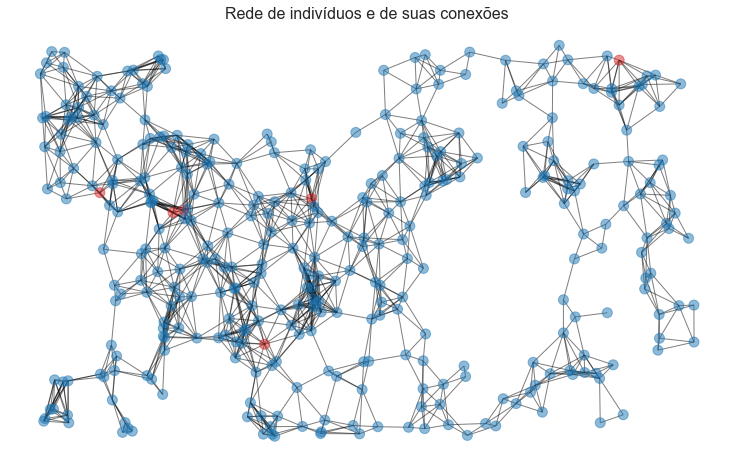

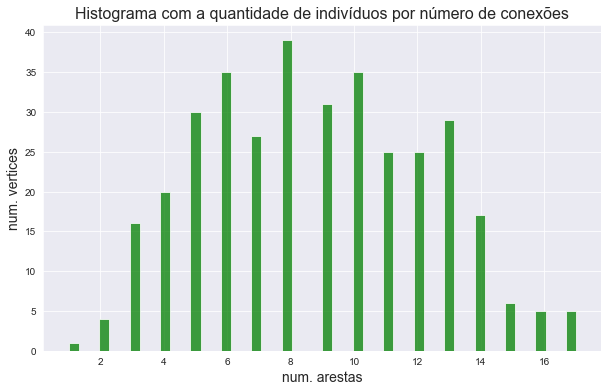

In [20]:
num_medio_conexoes_r = analise_grafo(G_r, info=True, node_size=100, pos=attr_pos, hist=True)

### Rede global

Agora, construímos uma rede completa, usando a localização dos indivíduos feita na construção do grafo geométrico, mas com conexões com peso decaindo de acordo com a distância entre os indivíduos.

In [21]:
G_c = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_c, attr_estado_0)

dist = lambda x, y: sum(abs(a - b)**2 for a, b in zip(x, y))**.5
#
# kernel function from Keeling & Rohani (2007)
# kernel = lambda d: d**-2.6
#
# kernel function from Ferguson et al (2005), but with different parameter values
a = 1.0 #
b = 1.5 #
kernel = lambda d: 1.0/(1.0 + (d/a)**b)
#
attr_kernel_dist = [(i, j, 
                     {'weight': kernel(dist(attr_pos[i], attr_pos[j]))}) 
                    for i in range(num_pop) 
                    for j in range(num_pop) if j != i]

G_c.add_edges_from(attr_kernel_dist)

#aux = G_c.size(weight='weight')/G_c.number_of_nodes()
#aux = [G_c.degree(i, weight='weight')
attr_transmissao = {(i, j): 
                    {'taxa de transmissao': beta_c * G_c.edges[i,j]['weight']/G_c.degree(i, weight='weight')}
                    for (i,j) in G_c.edges()
                   }

nx.set_edge_attributes(G_c, attr_transmissao)

#### Análise da rede

Número de vértices: 350
Número de arestas: 61075
Número de arestas com peso: 11401.472870844269
Número médio de conexões por indivíduo: 65.2


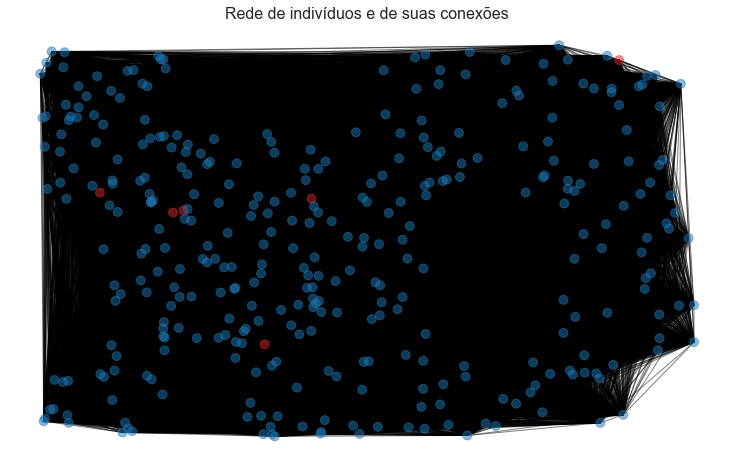

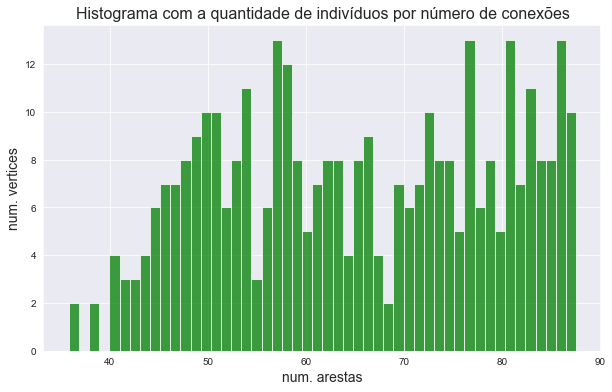

In [22]:
num_medio_conexoes_c = analise_grafo(G_c, info=True, node_size=80, pos=attr_pos, hist=True)


### Rede social (escola e trabalho)

- Lugares de trabalho e escolas têm a propriedade de congregar diversos indivíduos.

- Simulamos isso selecionando indivíduos aleatoriamento e conectando todos entre si.

- É claro que indivíduos em um mesmo local de trabalho ou escola tendem a formar grupos, com elos mais fortes, mas isso não é levado em consideração.

- Diferentes trabalhos também acarretam em conexões entre alguns de seus indivíduos, mas isso também não é implementado no modelo do Imperial College.|

- Naturalmente, nem todos participam de grupos assim (e.g. bebês, desempregados, aposentados), então nem todos serão selecionados neste processo.

- Posteriormente, dividiremos os locais entre escola e trabalho, mas agora vamos trabalhar com uma rede só.

#### Tamanho dos lugares

Em [Ferguson et al (2005)](#Referências), é mencionado que o tamanho, em número de trabalhadores, dos lugares de trabalho também satisfaz uma lei de potência.

Aqui, não vamos nos preocupar muito com a forma exata dessa distribuição.

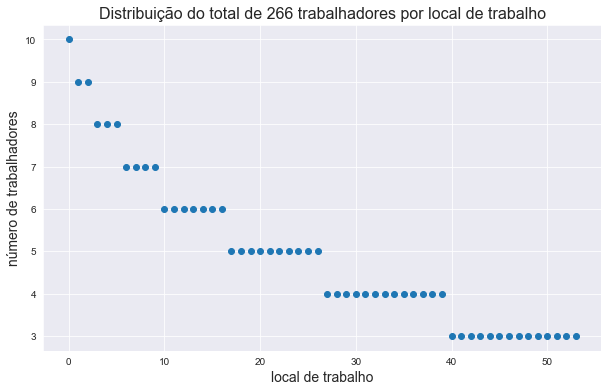

In [23]:
rs_tamanho = [10, 9, 9, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
           5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
#print('Total de indivíduos nos lugares de trabalho/escola:', )
plt.figure(figsize=(10,6))
plt.plot(rs_tamanho, 'o')
plt.xlabel('local de trabalho', fontsize=14)
plt.ylabel('número de trabalhadores', fontsize=14)
plt.title(f'Distribuição do total de {sum(rs_tamanho)} trabalhadores por local de trabalho', fontsize=16)
plt.show()

#### Construção da rede

In [24]:
G_s = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_s, attr_estado_0)
random.seed(721)
pop_index = list(range(num_pop))
membros = dict()

for j in range(len(rs_tamanho)):
    individuos_aleatorios = random.sample(pop_index, rs_tamanho[j])
    for i in individuos_aleatorios:
        pop_index.remove(i)
    membros.update({j: individuos_aleatorios})
    conexoes = [(m,n) for m in individuos_aleatorios for n in individuos_aleatorios if m != n ]
    G_s.add_edges_from(conexoes)

nx.set_edge_attributes(G_s, 1, 'weight')

attr_transmissao_s = {(i, j):
                      {'taxa de transmissao': beta_s / (1+G_s.degree(i))}
                      for (i,j) in G_s.edges()
                     }

#attr_transmissao_s = {(i, j):
#                      {'taxa de transmissao': beta_s / (1+G_s.degree(i))}
#                      for i in G_s.nodes for j in G_s.nodes}

nx.set_edge_attributes(G_s, attr_transmissao_s)

In [25]:
# sanity check
print(beta_s)
print(G_s.degree(0,185))
print(beta_s / G_s.degree(0,185))
print(attr_transmissao_s[0,185])
print(G_s.edges[(0,185)])
#G_s.edges(data=True)

0.22
8
0.0275
{'taxa de transmissao': 0.024444444444444446}
{'weight': 1, 'taxa de transmissao': 0.024444444444444446}


#### Análise da rede

Número de vértices: 350
Número de arestas: 610
Número de arestas com peso: 610.0
Número médio de conexões por indivíduo: 3.5


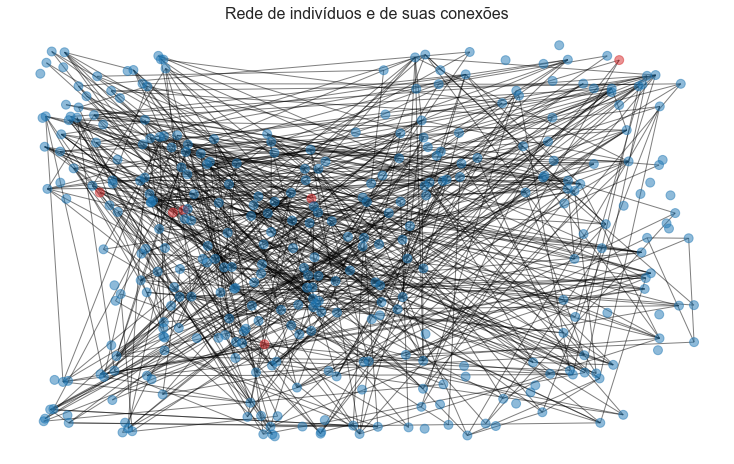

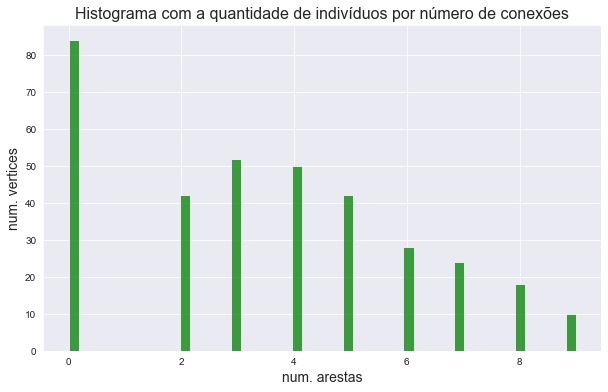

In [26]:
num_medio_conexoes_s = analise_grafo(G_s, info=True, node_size=80, pos=attr_pos, hist=True)

## Conjuntos de redes

- Dessa vez, não combinamos as redes em uma só.

- Consideramos o conjunto das redes, formando uma lista, com cada rede e a sua taxa de contágio.

### Combinando todos as redes

- Aqui, combinamos as redes com a função [nx.compose_all](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.operators.all.compose_all.html):

```python
G_a = nx.compose_all([G_c, G_s, G_r])
``` 

- Essa função é uma união de vértices e arestas, com a propriedade de incluir todos os atributos correspondentes.

- É importante observar que, se um atributo está presente em mais de um vértice ou aresta, então o atributo do último da lista é selecionado.

- Isso é suficiente no caso do atributo `weight`, que só não é igual a 1 na rede global, que colocamos, então, como primeiro da lista.

- No entanto, no caso do atributo `taxa de transmissao`, queremos somar os atributos, então precisamos aplicar isso.

In [27]:
G_a = nx.compose_all([G_c, G_s, G_r])

In [28]:
for (u, v, w) in G_c.edges.data('taxa de transmissao', default=0):
    G_a.edges[u,v]['taxa de transmissao'] = G_c.edges[u,v]['taxa de transmissao']
    if (u, v) in G_s.edges:
        G_a.edges[u, v]['taxa de transmissao'] += G_s.edges[u,v]['taxa de transmissao']
    if (u, v) in G_r.edges:
        G_a.edges[u, v]['taxa de transmissao'] += G_r.edges[u,v]['taxa de transmissao']

#### Análise da rede

Número de vértices: 350
Número de arestas: 61075
Número de arestas com peso: 12192.96040059164
Número médio de conexões por indivíduo: 69.7


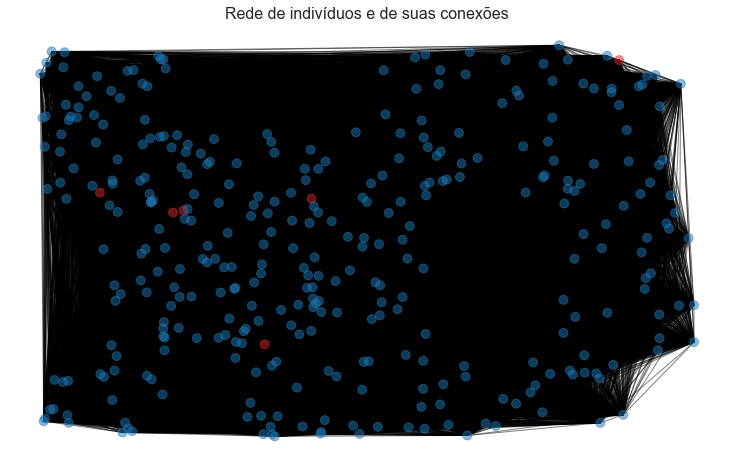

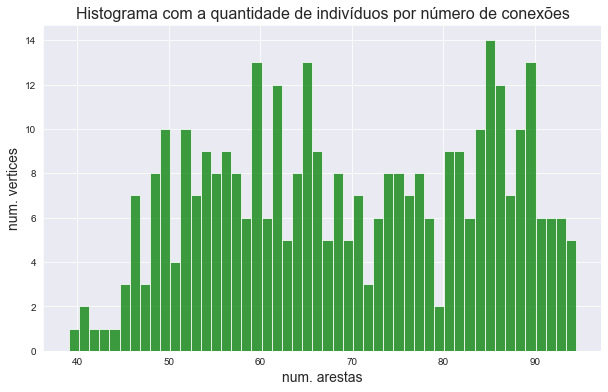

In [29]:
num_medio_conexoes_a = analise_grafo(G_a, info=True, node_size=80, pos=attr_pos, hist=True)

### Combinando apenas as redes residencial e social

Número de vértices: 350
Número de arestas: 2132
Número de arestas com peso: 2132.0
Número médio de conexões por indivíduo: 12.2


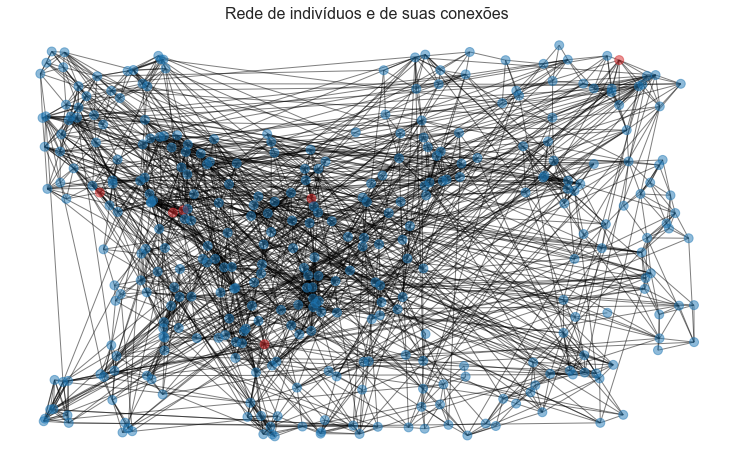

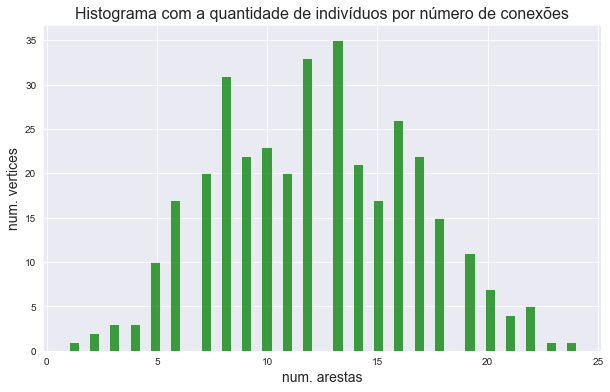

In [30]:
G_rs = nx.compose(G_s, G_r)
for (u, v, w) in G_rs.edges.data('taxa de transmissao', default=0):
    if (u, v) in G_s.edges and (u,v) in G_r.edges:
        G_rs.edges[u, v]['taxa de transmissao'] = \
            G_r.edges[u,v]['taxa de transmissao'] + G_s.edges[u,v]['taxa de transmissao']
num_medio_conexoes_rs = analise_grafo(G_rs, info=True, node_size=80, pos=attr_pos, hist=True)

In [31]:
[[u,v,G_rs.edges[u, v]['taxa de transmissao']] for (u,v) in G_rs.edges if u == 0]

[[0, 185, 0.024444444444444446],
 [0, 126, 0.024444444444444446],
 [0, 159, 0.024444444444444446],
 [0, 100, 0.024444444444444446],
 [0, 234, 0.024444444444444446],
 [0, 233, 0.024444444444444446],
 [0, 292, 0.024444444444444446],
 [0, 303, 0.024444444444444446],
 [0, 5, 0.020625263131049742],
 [0, 4, 0.020625263131049742],
 [0, 7, 0.020625263131049742],
 [0, 6, 0.020625263131049742],
 [0, 21, 0.020625263131049742],
 [0, 23, 0.020625263131049742],
 [0, 12, 0.020625263131049742],
 [0, 2, 0.020625263131049742],
 [0, 57, 0.020625263131049742],
 [0, 11, 0.020625263131049742],
 [0, 14, 0.020625263131049742],
 [0, 13, 0.020625263131049742],
 [0, 16, 0.020625263131049742],
 [0, 25, 0.020625263131049742]]

In [32]:
[[u,v,G_rs.edges[u, v]['taxa de transmissao']] for (u,v) in G_rs.edges if u == 1]

[[1, 198, 0.07333333333333333],
 [1, 183, 0.07333333333333333],
 [1, 4, 0.04292907243315766],
 [1, 3, 0.04292907243315766],
 [1, 9, 0.04292907243315766],
 [1, 8, 0.04292907243315766],
 [1, 10, 0.04292907243315766]]

In [33]:
G_rs.edges[21, 23]['taxa de transmissao']

0.05062692134002045

In [34]:
print('G_r:')
print((3,1) in G_r.edges)
if (3,1) in G_r.edges:
    print(G_r.edges[3,1])
else:
    print('not in edges')
print(nx.to_numpy_matrix(G_r, weight = 'taxa de transmissao')[3,1])
print()

print('G_s:')
print((3,1) in G_s.edges)
if (3,1) in G_s.edges:
    print(G_s.edges[3,1])
else:
    print('not in edges')
print(nx.to_numpy_matrix(G_s, weight = 'taxa de transmissao')[3,1])
print()

print('G_rs:')
print((3,1) in G_rs.edges)
print(G_rs.edges[3,1])
print(nx.to_numpy_matrix(G_rs, weight = 'taxa de transmissao')[3,1])
print()

G_r:
True
{'weight': 1, 'taxa de transmissao': 0.04292907243315766}
0.04292907243315766

G_s:
False
not in edges
0.0

G_rs:
True
{'weight': 1, 'taxa de transmissao': 0.04292907243315766}
0.04292907243315766



## Simulações

A seguir, simulações em cada uma das redes.

Rede de residências


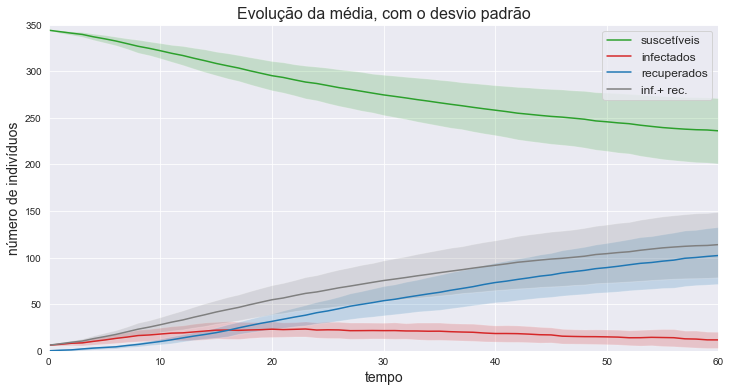

CPU times: user 11.9 s, sys: 174 ms, total: 12.1 s
Wall time: 6.53 s


In [35]:
%%time
print('Rede de residências')
X_r = evolucao_grafo_estruturado(pop_0, G_r, gamma, tempos, num_sim, show='sd')

Rede de locais de estudo e de trabalho 


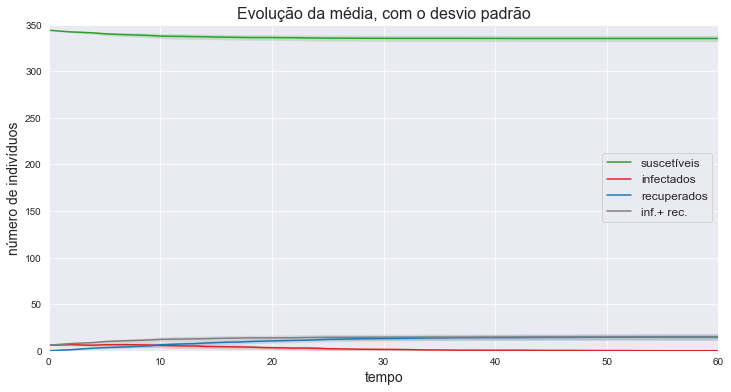

CPU times: user 14.5 s, sys: 974 ms, total: 15.5 s
Wall time: 8.9 s


In [36]:
%%time
print('Rede de locais de estudo e de trabalho ')
X_s = evolucao_grafo_estruturado(pop_0, G_s, gamma, tempos, num_sim, show='sd')

Rede global


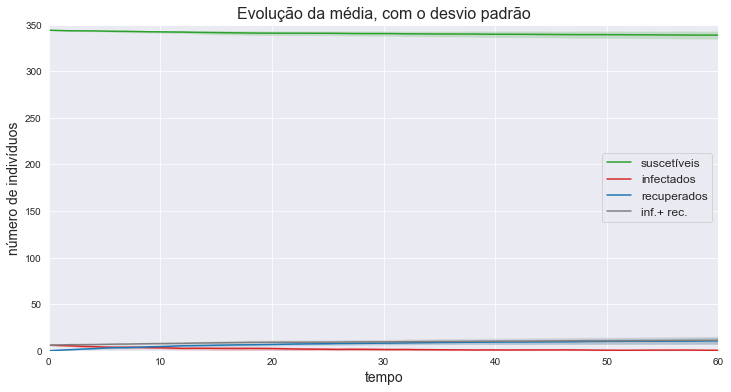

CPU times: user 16 s, sys: 1.18 s, total: 17.2 s
Wall time: 9.96 s


In [37]:
%%time
print('Rede global')
X_c = evolucao_grafo_estruturado(pop_0, G_c, gamma, tempos, num_sim, show='sd')

Redes residencial e social


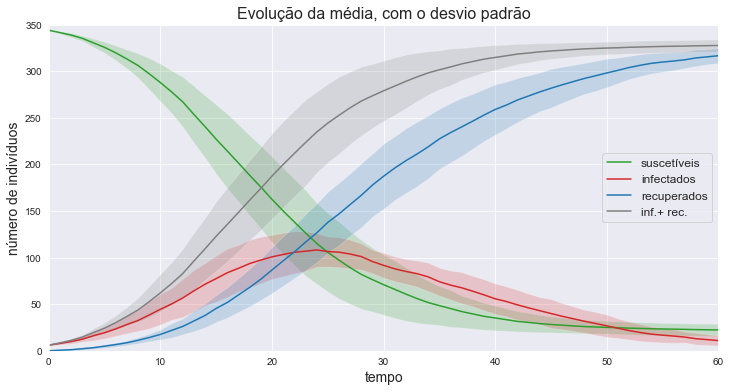

CPU times: user 17 s, sys: 1.62 s, total: 18.6 s
Wall time: 11.4 s


In [38]:
%%time
print('Redes residencial e social')
X_rs = evolucao_grafo_estruturado(pop_0, G_rs, gamma, tempos, num_sim, show='sd')

Rede combinada


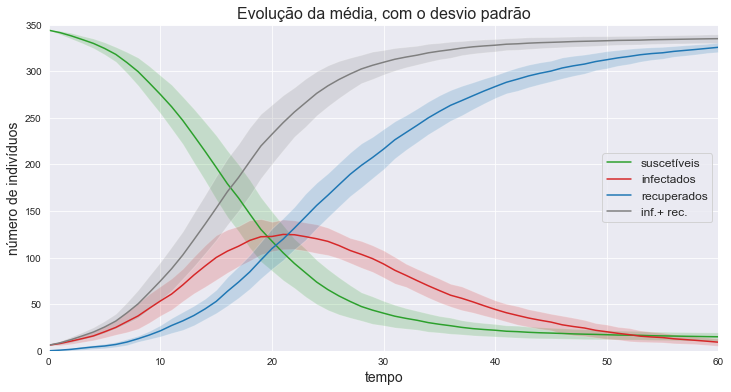

CPU times: user 15.6 s, sys: 1.27 s, total: 16.8 s
Wall time: 9.54 s


In [39]:
%%time
print('Rede combinada')
X_a = evolucao_grafo_estruturado(pop_0, G_a, gamma, tempos, num_sim, show='sd')

### Comparação com o SIR compartimental

In [40]:
X = evolucao_SIR(pop_0 = [num_pop-I_0, I_0, 0], beta=beta, gamma=gamma, tempos = tempos)

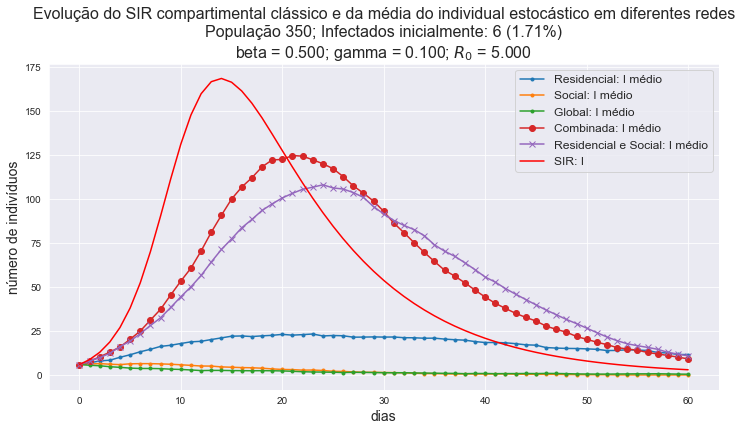

In [41]:
plt.figure(figsize=(12,6))
#plt.ylim(0, num_pop/2)

# exibe os gráficos das médias
plt.plot(tempos, X_r.I_mean, '.-', label='Residencial: I médio')
plt.plot(tempos, X_s.I_mean, '.-', label='Social: I médio')
plt.plot(tempos, X_c.I_mean, '.-', label='Global: I médio')
plt.plot(tempos, X_a.I_mean, 'o-', label='Combinada: I médio')
plt.plot(tempos, X_rs.I_mean, 'x-', label='Residencial e Social: I médio')
plt.plot(tempos, X.I, 'red', label='SIR: I')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do SIR compartimental clássico e da média do individual estocástico em diferentes redes\n'
          + f'População {num_pop}; Infectados inicialmente: {I_0} ({100*I_0/num_pop:.2f}%)\n'
          + f'beta = {beta:.3f}; gamma = {gamma:.3f}; $R_0$ = {beta/gamma:.3f}', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

# Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020 (Free Download).](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic
in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).)


- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2). 

- [Halloran ME, Ferguson NM, Eubank S, et al (2008), Modeling targeted layered containment of an influenza pandemic in the United States. Proc Natl Acad Sci U S A 105 (12), 4639–44 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/18332436/); veja, também, o [suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1).

- [Landscan data](https://landscan.ornl.gov/): dados da distribuição global da população, com resolução da ordem de $1\,km^2$ ($30''\times 30''$).

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)

- [I. Z. Kiss, J. Miller & P. L. Simon (2017), Mathematics of Epidemics on Networks: From Exact to Approximate Models, Springer-Verlag.](https://www.springer.com/br/book/9783319508047)

Veja a página [Imperial College - Covid 19](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/) para mais relatórios, publicações e outras informações do Imperial College.

<!--NAVIGATOR-->

---
[<- Modelos individuais estocásticos - redes e parâmetros](09.00-Modelos_individuais_redes_e_parametros.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos individuais estocásticos - implementação vetorial ->](11.00-Modelos_individuais_implementacao_vetorial.ipynb)